In [ ]:
#Providing Access to Google drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ARIMA(0, 0, 1) RMSE = 0.0051
ARIMA(0, 0, 2) RMSE = 0.0051
ARIMA(0, 0, 3) RMSE = 0.0048
ARIMA(0, 0, 4) RMSE = 0.0047
ARIMA(0, 0, 5) RMSE = 0.0050
ARIMA(0, 0, 6) RMSE = 0.0050
ARIMA(1, 0, 0) RMSE = 0.0051
ARIMA(1, 0, 1) RMSE = 0.0051
ARIMA(1, 0, 2) RMSE = 0.0041
ARIMA(1, 0, 3) RMSE = 0.0039
ARIMA(1, 0, 4) RMSE = 0.0045
ARIMA(1, 0, 5) RMSE = 0.0050
ARIMA(1, 0, 6) RMSE = 0.0047
ARIMA(2, 0, 0) RMSE = 0.0050
ARIMA(2, 0, 1) RMSE = 0.0042
ARIMA(2, 0, 2) RMSE = 0.0039
ARIMA(2, 0, 3) RMSE = 0.0047
ARIMA(2, 0, 4) RMSE = 0.0041
ARIMA(2, 0, 5) RMSE = 0.0040
ARIMA(2, 0, 6) RMSE = 0.0046
ARIMA(3, 0, 0) RMSE = 0.0045
ARIMA(3, 0, 1) RMSE = 0.0046
ARIMA(3, 0, 2) RMSE = 0.0043
ARIMA(3, 0, 3) RMSE = 0.0048
ARIMA(3, 0, 4) RMSE = 0.0049
ARIMA(3, 0, 5) RMSE = 0.0043
ARIMA(3, 0, 6) RMSE = 0.0048
ARIMA(4, 0, 0) RMSE = 0.0039
ARIMA(4, 0, 1) RMSE = 0.0041
ARIMA(4, 0, 2) RMSE = 0.0042
ARIMA(4, 0, 3) RMSE = 0.0048
ARIMA(4, 0, 4) RMSE = 0.0042
ARIMA(4, 0, 5) RMSE = 0.0044
ARIMA(4, 0, 6) RMSE = 0.0044
ARIMA(5, 0, 0)

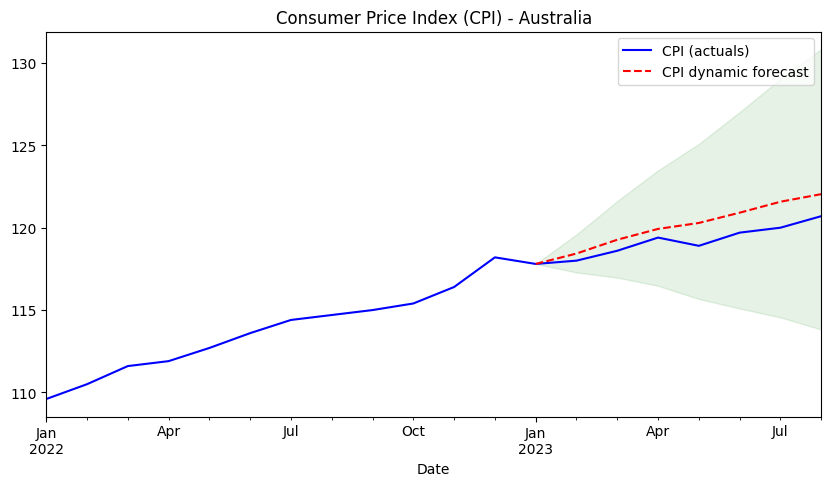

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

# Define a function for date parsing
def date_parser(dates):
    return pd.to_datetime(dates, format='%d/%m/%Y')

# Load and preprocess data
def load_and_preprocess_data(cpi_csv_path, cpi_weights_csv_path):
    cpi_aus = pd.read_csv(cpi_csv_path, parse_dates=['Date'], index_col='Date', date_parser=date_parser)
    cpi_weights = pd.read_csv(cpi_weights_csv_path, parse_dates=['Date'], index_col='Date', date_parser=date_parser)

    column_mapping = {
        'All-groups': 'cpi',
        'Food and non-alcoholic beverages': 'food',
        'Alcohol and tobacco': 'alcohol',
        'Clothing and footwear': 'clothing',
        'Housing': 'housing',
        'Furnishings, household equipment and services': 'household',
        'Health': 'health',
        'Transport': 'transport',
        'Communication': 'communication',
        'Recreation and culture': 'recreation',
        'Education': 'education',
        'Insurance and financial services': 'finance'
    }
    cpi_aus.rename(columns=column_mapping, inplace=True)
    cpi_weights.rename(columns=column_mapping, inplace=True)

    # Create log and differenced log columns using vectorized operations
    columns_to_process = ['cpi', 'food', 'alcohol', 'clothing', 'housing', 'household', 'health', 'transport', 'communication', 'recreation', 'education', 'finance']
    cpi_aus[[f'log{column}' for column in columns_to_process]] = np.log(cpi_aus[columns_to_process] + 1e-10)
    cpi_aus[[f'dlog{column}' for column in columns_to_process]] = cpi_aus[[f'log{column}' for column in columns_to_process]].diff()

    return cpi_aus, cpi_weights

# Load and preprocess the data
# Australian Bureau of Statistics
# https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/monthly-consumer-price-index-indicator/latest-release#using-price-indexes
cpi_csv_path = '/content/drive/MyDrive/ .... /CPI_AUS_20231022.csv'
# Monthly Consumer Price Index Indicator, Weighting Pattern, Australia
# https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/monthly-consumer-price-index-indicator/jul-2023
cpi_weights_csv_path = '/content/drive/MyDrive/ .... /CPI_AUS_Weights_2022_2023.csv'
cpi_aus, cpi_weights = load_and_preprocess_data(cpi_csv_path, cpi_weights_csv_path)

# Define a function for ARIMA model evaluation
def arima_model_evaluate(actuals, validation, order):
    sarimax_model = SARIMAX(actuals, order=order).fit()
    prediction = sarimax_model.get_forecast(len(validation))
    predictions_df = prediction.conf_int(alpha=0.9)
    predictions_df["Predictions"] = sarimax_model.predict(start=predictions_df.index[0], end=predictions_df.index[-1])
    predictions_df.index = validation.index
    predictions_arima = predictions_df["Predictions"]
    rmse_score = rmse(validation, predictions_df["Predictions"])
    return rmse_score

# Define a function to optimize ARIMA model parameters
def optimize_arima(actuals, validation, p_values, d_values, q_values):
    best_rmse, best_config = float("inf"), None
    parameter_combinations = [(p, d, q) for p in p_values for d in d_values for q in q_values]
    for order in parameter_combinations:
        rmse_score = arima_model_evaluate(actuals, validation, order)
        if order == (0, 0, 0):
            continue
        elif rmse_score < best_rmse:
            best_rmse, best_config = rmse_score, order
        print(f'ARIMA{order} RMSE = {rmse_score:.4f}')
    print(f'Best Configuration: ARIMA{best_config}, RMSE = {best_rmse:.4f}')
    return best_config

# Train ARIMA model and get best configuration
t = 7
cpi_aus_train = cpi_aus.iloc[:-t]
cpi_aus_validation = cpi_aus.iloc[-t:]
actuals = cpi_aus_train['dlogcpi'].dropna()
validation = cpi_aus_validation['dlogcpi'].dropna()
p_values = range(0, 7)
d_values = range(0, 1)
q_values = range(0, 7)
best_config = optimize_arima(actuals, validation, p_values, d_values, q_values)
order = best_config

# Train the final ARIMA model with the best configuration
sarimax_model = SARIMAX(actuals, order=order).fit()
prediction = sarimax_model.get_forecast(len(validation))
predictions_df = prediction.conf_int()
predictions_df["Predictions"] = sarimax_model.predict(start=predictions_df.index[0], end=predictions_df.index[-1])
predictions_df.index = validation.index

# Combine forecasted columns in the original DataFrame
cpi_aus['cpipred_m'] = predictions_df['Predictions']
cpi_aus['logcpipred_m'] = np.nan
for i in range(t):
    if i == 0:
        cpi_aus['logcpipred_m'].iloc[-t] = cpi_aus['logcpi'].iloc[-t-1] + cpi_aus['cpipred_m'].iloc[-t]
    else:
        cpi_aus['logcpipred_m'].iloc[-t+i] = cpi_aus['logcpipred_m'].iloc[-t+i-1] + cpi_aus['cpipred_m'].iloc[-t+i]
cpi_aus['cpipred'] = np.exp(cpi_aus['logcpipred_m'])
cpi_aus['cpipred'].iloc[-t-1] = cpi_aus['cpi'].iloc[-t-1]

cpi_aus['cpipred_u'] = predictions_df['upper dlogcpi']
cpi_aus['logcpipred_u'] = np.nan
for i in range(t):
    if i == 0:
        cpi_aus['logcpipred_u'].iloc[-t] = cpi_aus['logcpi'].iloc[-t-1] + cpi_aus['cpipred_u'].iloc[-t]
    else:
        cpi_aus['logcpipred_u'].iloc[-t+i] = cpi_aus['logcpipred_u'].iloc[-t+i-1] + cpi_aus['cpipred_u'].iloc[-t+i]
cpi_aus['cpipred_upperbound'] = np.exp(cpi_aus['logcpipred_u'])
cpi_aus['cpipred_upperbound'].iloc[-t-1] = cpi_aus['cpi'].iloc[-t-1]

cpi_aus['cpipred_l'] = predictions_df['lower dlogcpi']
cpi_aus['logcpipred_l'] = np.nan
for i in range(t):
    if i == 0:
        cpi_aus['logcpipred_l'].iloc[-t] = cpi_aus['logcpi'].iloc[-t-1] + cpi_aus['cpipred_l'].iloc[-t]
    else:
        cpi_aus['logcpipred_l'].iloc[-t+i] = cpi_aus['logcpipred_l'].iloc[-t+i-1] + cpi_aus['cpipred_l'].iloc[-t+i]
cpi_aus['cpipred_lowerbound'] = np.exp(cpi_aus['logcpipred_l'])
cpi_aus['cpipred_lowerbound'].iloc[-t-1] = cpi_aus['cpi'].iloc[-t-1]

# Plot the chart
fig, ax = plt.subplots(figsize=(10, 5))
cpi_aus_chart = cpi_aus.iloc[-20:]
#plt.figure(figsize=(12, 6))
cpi_aus_chart['cpi'].plot(ax=ax, style='b', label='CPI (actuals)')
cpi_aus_chart['cpipred'].plot(ax=ax, style='r--', label='CPI dynamic forecast')
ax.fill_between(cpi_aus_chart.index, cpi_aus_chart['cpipred_upperbound'], cpi_aus_chart['cpipred_lowerbound'], color='g', alpha=0.1);
plt.title('Consumer Price Index (CPI) - Australia')
plt.legend()
plt.show()

In [ ]:
cpi_aus.tail(10)

,cpi,food,alcohol,clothing,housing,household,health,transport,communication,recreation,...,dlogfinance,cpipred_m,logcpipred_m,cpipred,cpipred_u,logcpipred_u,cpipred_upperbound,cpipred_l,logcpipred_l,cpipred_lowerbound
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-01,116.4,121.4,132.7,103.2,116.0,116.1,117.0,127.1,88.9,106.6,...,0.006401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01,118.2,122.4,132.4,104.4,117.2,116.9,117.2,124.5,89.1,118.3,...,0.013581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,117.8,122.3,132.8,100.6,118.2,115.0,118.1,124.9,89.1,114.6,...,0.000000,NaN,NaN,117.800000,NaN,NaN,117.800000,NaN,NaN,117.800000
2023-02-01,118.0,123.5,134.4,102.1,118.5,115.8,118.1,127.2,89.4,107.7,...,0.007168,0.005346,4.774334,118.431443,0.015070,4.784058,119.588713,-0.004378,4.764610,117.285373
2023-03-01,118.6,124.0,135.4,102.3,118.8,116.1,121.2,126.9,89.4,108.3,...,0.012423,0.007061,4.781395,119.270674,0.016808,4.800867,121.615772,-0.002686,4.761924,116.970796
2023-04-01,119.4,124.3,135.6,104.2,119.2,117.8,121.3,128.1,88.8,111.3,...,0.000000,0.005483,4.786878,119.926378,0.015230,4.816097,123.482138,-0.004265,4.757660,116.473009
2023-05-01,118.9,125.6,135.7,102.2,119.4,118.2,121.3,125.6,89.5,106.4,...,0.011399,0.003015,4.789893,120.288455,0.012914,4.829011,125.087152,-0.006885,4.750775,115.673851
2023-06-01,119.7,125.5,135.5,100.4,119.7,118.3,121.5,126.9,88.5,111.5,...,0.017287,0.005161,4.795053,120.910841,0.015341,4.844352,127.020936,-0.005020,4.745755,115.094660
2023-07-01,120.0,125.3,135.5,102.9,121.3,118.5,121.5,126.8,89.2,109.8,...,0.000000,0.005492,4.800546,121.576747,0.015679,4.860030,129.028134,-0.004694,4.741061,114.555678


cpi index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0051
ARIMA(0, 0, 2) RMSE = 0.0051
ARIMA(0, 0, 3) RMSE = 0.0048
ARIMA(0, 0, 4) RMSE = 0.0047
ARIMA(0, 0, 5) RMSE = 0.0050
ARIMA(0, 0, 6) RMSE = 0.0050
ARIMA(1, 0, 0) RMSE = 0.0051
ARIMA(1, 0, 1) RMSE = 0.0051
ARIMA(1, 0, 2) RMSE = 0.0041
ARIMA(1, 0, 3) RMSE = 0.0039
ARIMA(1, 0, 4) RMSE = 0.0045
ARIMA(1, 0, 5) RMSE = 0.0050
ARIMA(1, 0, 6) RMSE = 0.0047
ARIMA(2, 0, 0) RMSE = 0.0050
ARIMA(2, 0, 1) RMSE = 0.0042
ARIMA(2, 0, 2) RMSE = 0.0039
ARIMA(2, 0, 3) RMSE = 0.0047
ARIMA(2, 0, 4) RMSE = 0.0041
ARIMA(2, 0, 5) RMSE = 0.0040
ARIMA(2, 0, 6) RMSE = 0.0046
ARIMA(3, 0, 0) RMSE = 0.0045
ARIMA(3, 0, 1) RMSE = 0.0046
ARIMA(3, 0, 2) RMSE = 0.0043
ARIMA(3, 0, 3) RMSE = 0.0048
ARIMA(3, 0, 4) RMSE = 0.0049
ARIMA(3, 0, 5) RMSE = 0.0043
ARIMA(3, 0, 6) RMSE = 0.0048
ARIMA(4, 0, 0) RMSE = 0.0039
ARIMA(4, 0, 1) RMSE = 0.0041
ARIMA(4, 0, 2) RMSE = 0.0042
ARIMA(4, 0, 3) RMSE = 0.0048
ARIMA(4, 0, 4) RMSE = 0.0042
ARIMA(4, 0, 5) RMSE = 0.0044
ARIMA(4, 0,

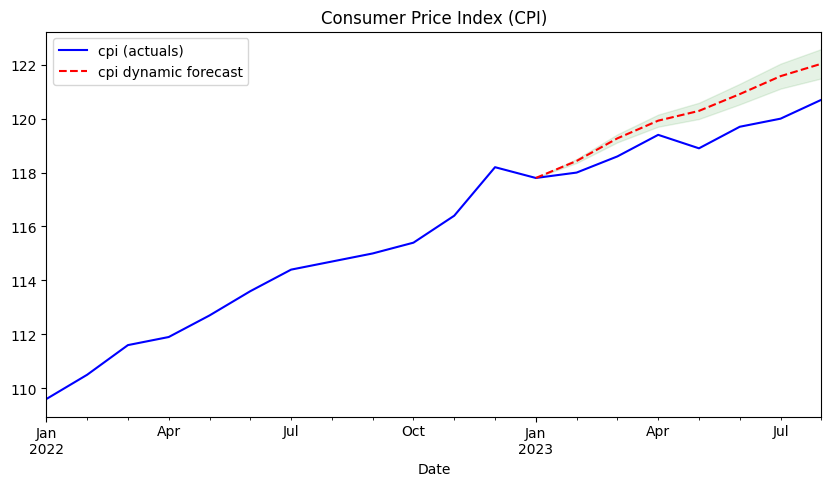

food index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0068
ARIMA(0, 0, 2) RMSE = 0.0068
ARIMA(0, 0, 3) RMSE = 0.0065
ARIMA(0, 0, 4) RMSE = 0.0061
ARIMA(0, 0, 5) RMSE = 0.0062
ARIMA(0, 0, 6) RMSE = 0.0063
ARIMA(1, 0, 0) RMSE = 0.0067
ARIMA(1, 0, 1) RMSE = 0.0067
ARIMA(1, 0, 2) RMSE = 0.0055
ARIMA(1, 0, 3) RMSE = 0.0057
ARIMA(1, 0, 4) RMSE = 0.0057
ARIMA(1, 0, 5) RMSE = 0.0052
ARIMA(1, 0, 6) RMSE = 0.0072
ARIMA(2, 0, 0) RMSE = 0.0068
ARIMA(2, 0, 1) RMSE = 0.0067
ARIMA(2, 0, 2) RMSE = 0.0049
ARIMA(2, 0, 3) RMSE = 0.0059
ARIMA(2, 0, 4) RMSE = 0.0067
ARIMA(2, 0, 5) RMSE = 0.0051
ARIMA(2, 0, 6) RMSE = 0.0059
ARIMA(3, 0, 0) RMSE = 0.0058
ARIMA(3, 0, 1) RMSE = 0.0056
ARIMA(3, 0, 2) RMSE = 0.0048
ARIMA(3, 0, 3) RMSE = 0.0051
ARIMA(3, 0, 4) RMSE = 0.0059
ARIMA(3, 0, 5) RMSE = 0.0061
ARIMA(3, 0, 6) RMSE = 0.0057
ARIMA(4, 0, 0) RMSE = 0.0058
ARIMA(4, 0, 1) RMSE = 0.0057
ARIMA(4, 0, 2) RMSE = 0.0051
ARIMA(4, 0, 3) RMSE = 0.0050
ARIMA(4, 0, 4) RMSE = 0.0059
ARIMA(4, 0, 5) RMSE = 0.0052
ARIMA(4, 0

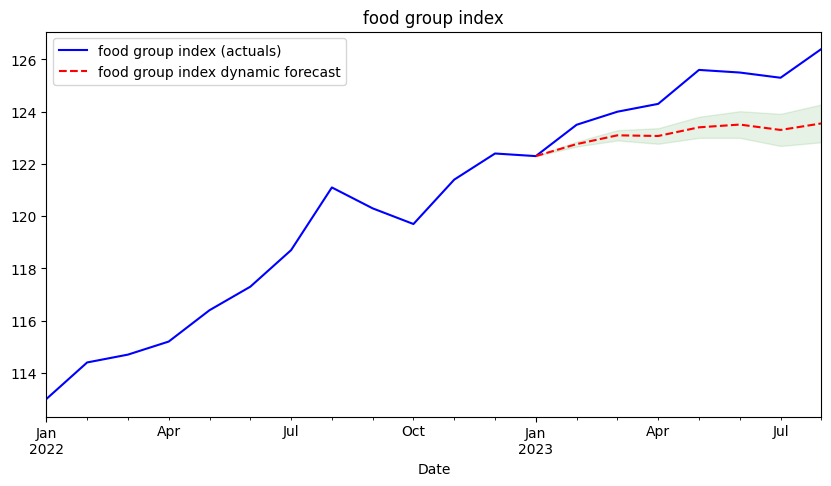

alcohol index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0068
ARIMA(0, 0, 2) RMSE = 0.0067
ARIMA(0, 0, 3) RMSE = 0.0067
ARIMA(0, 0, 4) RMSE = 0.0065
ARIMA(0, 0, 5) RMSE = 0.0065
ARIMA(0, 0, 6) RMSE = 0.0059
ARIMA(1, 0, 0) RMSE = 0.0068
ARIMA(1, 0, 1) RMSE = 0.0067
ARIMA(1, 0, 2) RMSE = 0.0056
ARIMA(1, 0, 3) RMSE = 0.0063
ARIMA(1, 0, 4) RMSE = 0.0058
ARIMA(1, 0, 5) RMSE = 0.0061
ARIMA(1, 0, 6) RMSE = 0.0058
ARIMA(2, 0, 0) RMSE = 0.0067
ARIMA(2, 0, 1) RMSE = 0.0067
ARIMA(2, 0, 2) RMSE = 0.0067
ARIMA(2, 0, 3) RMSE = 0.0056
ARIMA(2, 0, 4) RMSE = 0.0055
ARIMA(2, 0, 5) RMSE = 0.0059
ARIMA(2, 0, 6) RMSE = 0.0053
ARIMA(3, 0, 0) RMSE = 0.0068
ARIMA(3, 0, 1) RMSE = 0.0068
ARIMA(3, 0, 2) RMSE = 0.0068
ARIMA(3, 0, 3) RMSE = 0.0052
ARIMA(3, 0, 4) RMSE = 0.0054
ARIMA(3, 0, 5) RMSE = 0.0057
ARIMA(3, 0, 6) RMSE = 0.0053
ARIMA(4, 0, 0) RMSE = 0.0064
ARIMA(4, 0, 1) RMSE = 0.0065
ARIMA(4, 0, 2) RMSE = 0.0061
ARIMA(4, 0, 3) RMSE = 0.0055
ARIMA(4, 0, 4) RMSE = 0.0049
ARIMA(4, 0, 5) RMSE = 0.0062
ARIMA(4

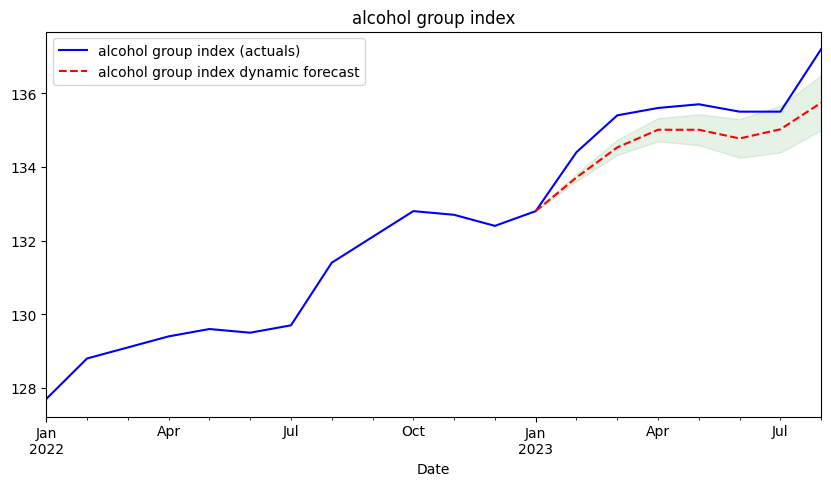

clothing index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0153
ARIMA(0, 0, 2) RMSE = 0.0156
ARIMA(0, 0, 3) RMSE = 0.0148
ARIMA(0, 0, 4) RMSE = 0.0161
ARIMA(0, 0, 5) RMSE = 0.0149
ARIMA(0, 0, 6) RMSE = 0.0149
ARIMA(1, 0, 0) RMSE = 0.0155
ARIMA(1, 0, 1) RMSE = 0.0167
ARIMA(1, 0, 2) RMSE = 0.0166
ARIMA(1, 0, 3) RMSE = 0.0148
ARIMA(1, 0, 4) RMSE = 0.0163
ARIMA(1, 0, 5) RMSE = 0.0147
ARIMA(1, 0, 6) RMSE = 0.0153
ARIMA(2, 0, 0) RMSE = 0.0159
ARIMA(2, 0, 1) RMSE = 0.0165
ARIMA(2, 0, 2) RMSE = 0.0170
ARIMA(2, 0, 3) RMSE = 0.0155
ARIMA(2, 0, 4) RMSE = 0.0147
ARIMA(2, 0, 5) RMSE = 0.0160
ARIMA(2, 0, 6) RMSE = 0.0150
ARIMA(3, 0, 0) RMSE = 0.0135
ARIMA(3, 0, 1) RMSE = 0.0139
ARIMA(3, 0, 2) RMSE = 0.0143
ARIMA(3, 0, 3) RMSE = 0.0160
ARIMA(3, 0, 4) RMSE = 0.0168
ARIMA(3, 0, 5) RMSE = 0.0174
ARIMA(3, 0, 6) RMSE = 0.0180
ARIMA(4, 0, 0) RMSE = 0.0140
ARIMA(4, 0, 1) RMSE = 0.0143
ARIMA(4, 0, 2) RMSE = 0.0140
ARIMA(4, 0, 3) RMSE = 0.0159
ARIMA(4, 0, 4) RMSE = 0.0137
ARIMA(4, 0, 5) RMSE = 0.0151
ARIMA(

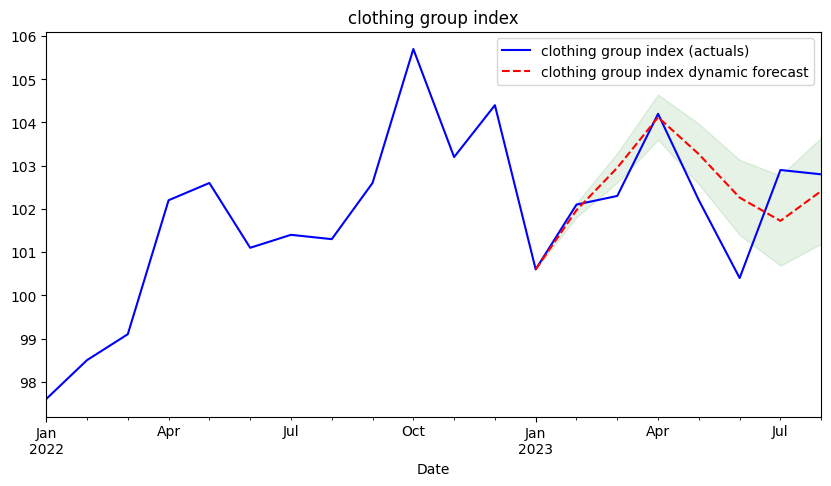

housing index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0054
ARIMA(0, 0, 2) RMSE = 0.0054
ARIMA(0, 0, 3) RMSE = 0.0053
ARIMA(0, 0, 4) RMSE = 0.0054
ARIMA(0, 0, 5) RMSE = 0.0054
ARIMA(0, 0, 6) RMSE = 0.0048
ARIMA(1, 0, 0) RMSE = 0.0050
ARIMA(1, 0, 1) RMSE = 0.0053
ARIMA(1, 0, 2) RMSE = 0.0052
ARIMA(1, 0, 3) RMSE = 0.0051
ARIMA(1, 0, 4) RMSE = 0.0055
ARIMA(1, 0, 5) RMSE = 0.0045
ARIMA(1, 0, 6) RMSE = 0.0045
ARIMA(2, 0, 0) RMSE = 0.0050
ARIMA(2, 0, 1) RMSE = 0.0050
ARIMA(2, 0, 2) RMSE = 0.0054
ARIMA(2, 0, 3) RMSE = 0.0052
ARIMA(2, 0, 4) RMSE = 0.0055
ARIMA(2, 0, 5) RMSE = 0.0045
ARIMA(2, 0, 6) RMSE = 0.0046
ARIMA(3, 0, 0) RMSE = 0.0051
ARIMA(3, 0, 1) RMSE = 0.0052
ARIMA(3, 0, 2) RMSE = 0.0056
ARIMA(3, 0, 3) RMSE = 0.0057
ARIMA(3, 0, 4) RMSE = 0.0056
ARIMA(3, 0, 5) RMSE = 0.0056
ARIMA(3, 0, 6) RMSE = 0.0066
ARIMA(4, 0, 0) RMSE = 0.0056
ARIMA(4, 0, 1) RMSE = 0.0058
ARIMA(4, 0, 2) RMSE = 0.0055
ARIMA(4, 0, 3) RMSE = 0.0062
ARIMA(4, 0, 4) RMSE = 0.0050
ARIMA(4, 0, 5) RMSE = 0.0050
ARIMA(4

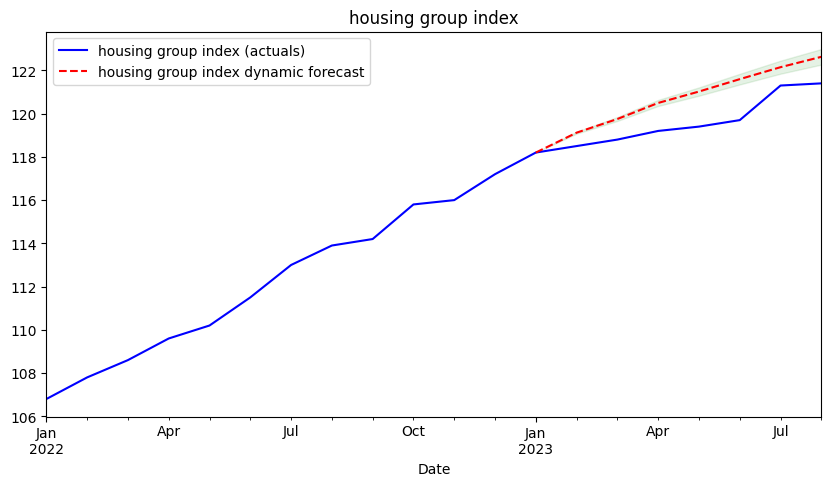

household index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0064
ARIMA(0, 0, 2) RMSE = 0.0063
ARIMA(0, 0, 3) RMSE = 0.0072
ARIMA(0, 0, 4) RMSE = 0.0055
ARIMA(0, 0, 5) RMSE = 0.0055
ARIMA(0, 0, 6) RMSE = 0.0065
ARIMA(1, 0, 0) RMSE = 0.0064
ARIMA(1, 0, 1) RMSE = 0.0064
ARIMA(1, 0, 2) RMSE = 0.0070
ARIMA(1, 0, 3) RMSE = 0.0061
ARIMA(1, 0, 4) RMSE = 0.0055
ARIMA(1, 0, 5) RMSE = 0.0055
ARIMA(1, 0, 6) RMSE = 0.0061
ARIMA(2, 0, 0) RMSE = 0.0064
ARIMA(2, 0, 1) RMSE = 0.0069
ARIMA(2, 0, 2) RMSE = 0.0065
ARIMA(2, 0, 3) RMSE = 0.0054
ARIMA(2, 0, 4) RMSE = 0.0056
ARIMA(2, 0, 5) RMSE = 0.0060
ARIMA(2, 0, 6) RMSE = 0.0064
ARIMA(3, 0, 0) RMSE = 0.0057
ARIMA(3, 0, 1) RMSE = 0.0057
ARIMA(3, 0, 2) RMSE = 0.0058
ARIMA(3, 0, 3) RMSE = 0.0059
ARIMA(3, 0, 4) RMSE = 0.0060
ARIMA(3, 0, 5) RMSE = 0.0060
ARIMA(3, 0, 6) RMSE = 0.0065
ARIMA(4, 0, 0) RMSE = 0.0056
ARIMA(4, 0, 1) RMSE = 0.0056
ARIMA(4, 0, 2) RMSE = 0.0058
ARIMA(4, 0, 3) RMSE = 0.0060
ARIMA(4, 0, 4) RMSE = 0.0059
ARIMA(4, 0, 5) RMSE = 0.0059
ARIMA

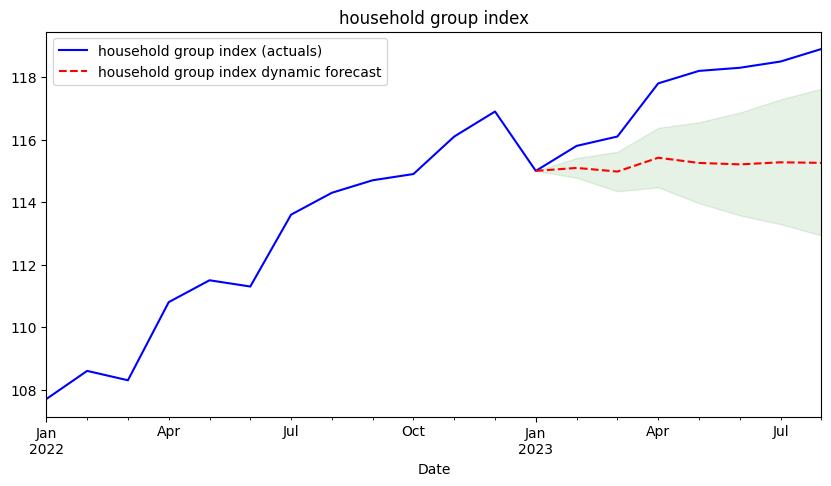

health index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0099
ARIMA(0, 0, 2) RMSE = 0.0101
ARIMA(0, 0, 3) RMSE = 0.0100
ARIMA(0, 0, 4) RMSE = 0.0104
ARIMA(0, 0, 5) RMSE = 0.0104
ARIMA(0, 0, 6) RMSE = 0.0104
ARIMA(1, 0, 0) RMSE = 0.0095
ARIMA(1, 0, 1) RMSE = 0.0099
ARIMA(1, 0, 2) RMSE = 0.0101
ARIMA(1, 0, 3) RMSE = 0.0101
ARIMA(1, 0, 4) RMSE = 0.0104
ARIMA(1, 0, 5) RMSE = 0.0105
ARIMA(1, 0, 6) RMSE = 0.0105
ARIMA(2, 0, 0) RMSE = 0.0101
ARIMA(2, 0, 1) RMSE = 0.0102
ARIMA(2, 0, 2) RMSE = 0.0102
ARIMA(2, 0, 3) RMSE = 0.0102
ARIMA(2, 0, 4) RMSE = 0.0102
ARIMA(2, 0, 5) RMSE = 0.0104
ARIMA(2, 0, 6) RMSE = 0.0103
ARIMA(3, 0, 0) RMSE = 0.0102
ARIMA(3, 0, 1) RMSE = 0.0101
ARIMA(3, 0, 2) RMSE = 0.0102
ARIMA(3, 0, 3) RMSE = 0.0104
ARIMA(3, 0, 4) RMSE = 0.0104
ARIMA(3, 0, 5) RMSE = 0.0104
ARIMA(3, 0, 6) RMSE = 0.0103
ARIMA(4, 0, 0) RMSE = 0.0103
ARIMA(4, 0, 1) RMSE = 0.0102
ARIMA(4, 0, 2) RMSE = 0.0103
ARIMA(4, 0, 3) RMSE = 0.0101
ARIMA(4, 0, 4) RMSE = 0.0104
ARIMA(4, 0, 5) RMSE = 0.0104
ARIMA(4,

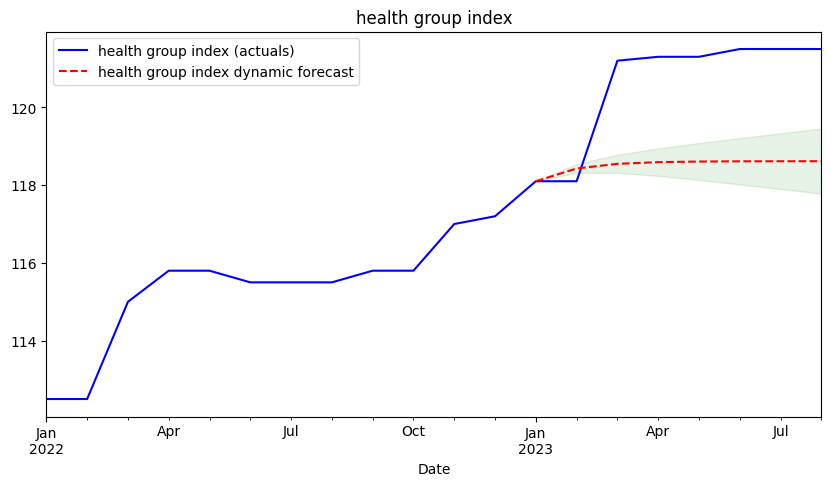

transport index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0175
ARIMA(0, 0, 2) RMSE = 0.0172
ARIMA(0, 0, 3) RMSE = 0.0175
ARIMA(0, 0, 4) RMSE = 0.0176
ARIMA(0, 0, 5) RMSE = 0.0174
ARIMA(0, 0, 6) RMSE = 0.0176
ARIMA(1, 0, 0) RMSE = 0.0176
ARIMA(1, 0, 1) RMSE = 0.0174
ARIMA(1, 0, 2) RMSE = 0.0173
ARIMA(1, 0, 3) RMSE = 0.0176
ARIMA(1, 0, 4) RMSE = 0.0177
ARIMA(1, 0, 5) RMSE = 0.0174
ARIMA(1, 0, 6) RMSE = 0.0177
ARIMA(2, 0, 0) RMSE = 0.0172
ARIMA(2, 0, 1) RMSE = 0.0172
ARIMA(2, 0, 2) RMSE = 0.0177
ARIMA(2, 0, 3) RMSE = 0.0175
ARIMA(2, 0, 4) RMSE = 0.0173
ARIMA(2, 0, 5) RMSE = 0.0175
ARIMA(2, 0, 6) RMSE = 0.0210
ARIMA(3, 0, 0) RMSE = 0.0172
ARIMA(3, 0, 1) RMSE = 0.0172
ARIMA(3, 0, 2) RMSE = 0.0177
ARIMA(3, 0, 3) RMSE = 0.0180
ARIMA(3, 0, 4) RMSE = 0.0175
ARIMA(3, 0, 5) RMSE = 0.0172
ARIMA(3, 0, 6) RMSE = 0.0175
ARIMA(4, 0, 0) RMSE = 0.0174
ARIMA(4, 0, 1) RMSE = 0.0175
ARIMA(4, 0, 2) RMSE = 0.0173
ARIMA(4, 0, 3) RMSE = 0.0175
ARIMA(4, 0, 4) RMSE = 0.0176
ARIMA(4, 0, 5) RMSE = 0.0166
ARIMA

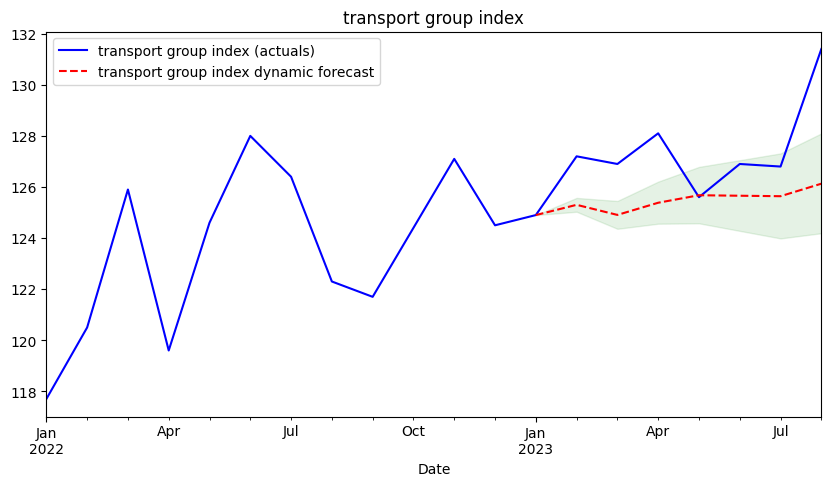

communication index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0091
ARIMA(0, 0, 2) RMSE = 0.0091
ARIMA(0, 0, 3) RMSE = 0.0092
ARIMA(0, 0, 4) RMSE = 0.0092
ARIMA(0, 0, 5) RMSE = 0.0092
ARIMA(0, 0, 6) RMSE = 0.0093
ARIMA(1, 0, 0) RMSE = 0.0091
ARIMA(1, 0, 1) RMSE = 0.0090
ARIMA(1, 0, 2) RMSE = 0.0091
ARIMA(1, 0, 3) RMSE = 0.0092
ARIMA(1, 0, 4) RMSE = 0.0092
ARIMA(1, 0, 5) RMSE = 0.0092
ARIMA(1, 0, 6) RMSE = 0.0093
ARIMA(2, 0, 0) RMSE = 0.0092
ARIMA(2, 0, 1) RMSE = 0.0092
ARIMA(2, 0, 2) RMSE = 0.0091
ARIMA(2, 0, 3) RMSE = 0.0092
ARIMA(2, 0, 4) RMSE = 0.0089
ARIMA(2, 0, 5) RMSE = 0.0094
ARIMA(2, 0, 6) RMSE = 0.0093
ARIMA(3, 0, 0) RMSE = 0.0095
ARIMA(3, 0, 1) RMSE = 0.0095
ARIMA(3, 0, 2) RMSE = 0.0092
ARIMA(3, 0, 3) RMSE = 0.0099
ARIMA(3, 0, 4) RMSE = 0.0095
ARIMA(3, 0, 5) RMSE = 0.0086
ARIMA(3, 0, 6) RMSE = 0.0087
ARIMA(4, 0, 0) RMSE = 0.0096
ARIMA(4, 0, 1) RMSE = 0.0095
ARIMA(4, 0, 2) RMSE = 0.0093
ARIMA(4, 0, 3) RMSE = 0.0100
ARIMA(4, 0, 4) RMSE = 0.0095
ARIMA(4, 0, 5) RMSE = 0.0093
A

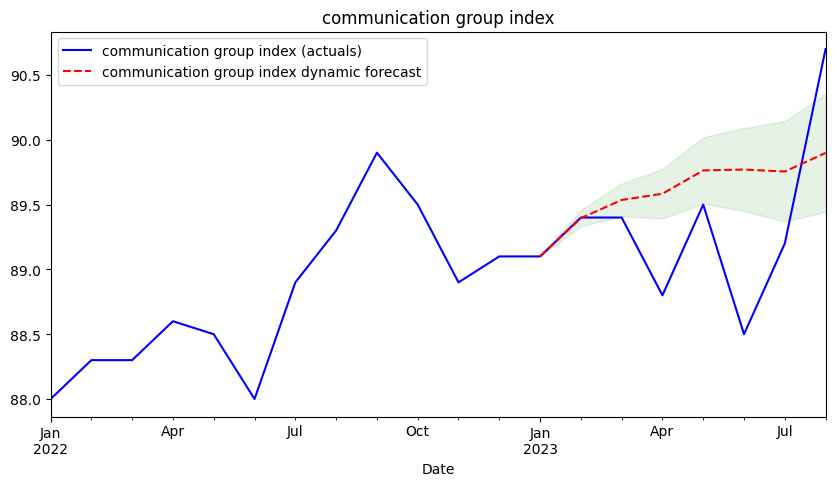

recreation index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0327
ARIMA(0, 0, 2) RMSE = 0.0282
ARIMA(0, 0, 3) RMSE = 0.0281
ARIMA(0, 0, 4) RMSE = 0.0274
ARIMA(0, 0, 5) RMSE = 0.0267
ARIMA(0, 0, 6) RMSE = 0.0313
ARIMA(1, 0, 0) RMSE = 0.0385
ARIMA(1, 0, 1) RMSE = 0.0319
ARIMA(1, 0, 2) RMSE = 0.0294
ARIMA(1, 0, 3) RMSE = 0.0280
ARIMA(1, 0, 4) RMSE = 0.0269
ARIMA(1, 0, 5) RMSE = 0.0269
ARIMA(1, 0, 6) RMSE = 0.0296
ARIMA(2, 0, 0) RMSE = 0.0259
ARIMA(2, 0, 1) RMSE = 0.0276
ARIMA(2, 0, 2) RMSE = 0.0252
ARIMA(2, 0, 3) RMSE = 0.0248
ARIMA(2, 0, 4) RMSE = 0.0277
ARIMA(2, 0, 5) RMSE = 0.0307
ARIMA(2, 0, 6) RMSE = 0.0325
ARIMA(3, 0, 0) RMSE = 0.0259
ARIMA(3, 0, 1) RMSE = 0.0270
ARIMA(3, 0, 2) RMSE = 0.0247
ARIMA(3, 0, 3) RMSE = 0.0243
ARIMA(3, 0, 4) RMSE = 0.0276
ARIMA(3, 0, 5) RMSE = 0.0253
ARIMA(3, 0, 6) RMSE = 0.0236
ARIMA(4, 0, 0) RMSE = 0.0239
ARIMA(4, 0, 1) RMSE = 0.0236
ARIMA(4, 0, 2) RMSE = 0.0236
ARIMA(4, 0, 3) RMSE = 0.0235
ARIMA(4, 0, 4) RMSE = 0.0245
ARIMA(4, 0, 5) RMSE = 0.0281
ARIM

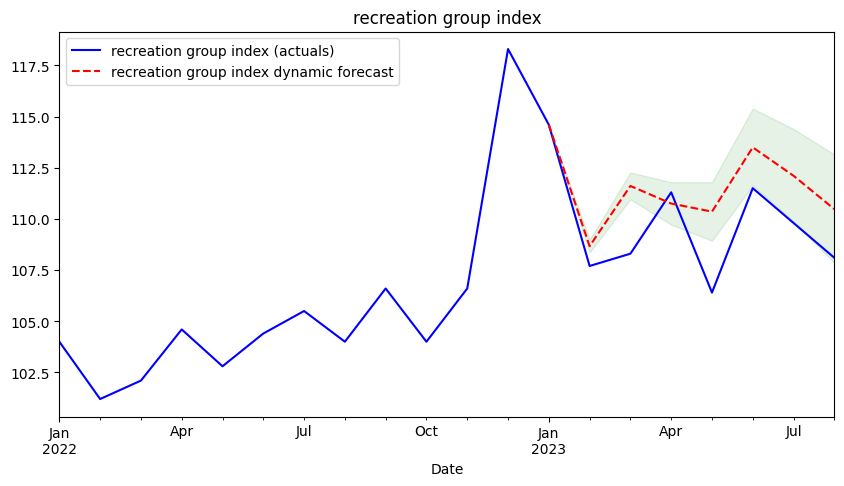

education index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0201
ARIMA(0, 0, 2) RMSE = 0.0201
ARIMA(0, 0, 3) RMSE = 0.0202
ARIMA(0, 0, 4) RMSE = 0.0202
ARIMA(0, 0, 5) RMSE = 0.0202
ARIMA(0, 0, 6) RMSE = 0.0202
ARIMA(1, 0, 0) RMSE = 0.0201
ARIMA(1, 0, 1) RMSE = 0.0201
ARIMA(1, 0, 2) RMSE = 0.0202
ARIMA(1, 0, 3) RMSE = 0.0202
ARIMA(1, 0, 4) RMSE = 0.0202
ARIMA(1, 0, 5) RMSE = 0.0202
ARIMA(1, 0, 6) RMSE = 0.0199
ARIMA(2, 0, 0) RMSE = 0.0201
ARIMA(2, 0, 1) RMSE = 0.0201
ARIMA(2, 0, 2) RMSE = 0.0188
ARIMA(2, 0, 3) RMSE = 0.0202
ARIMA(2, 0, 4) RMSE = 0.0202
ARIMA(2, 0, 5) RMSE = 0.0197
ARIMA(2, 0, 6) RMSE = 0.0191
ARIMA(3, 0, 0) RMSE = 0.0202
ARIMA(3, 0, 1) RMSE = 0.0202
ARIMA(3, 0, 2) RMSE = 0.0202
ARIMA(3, 0, 3) RMSE = 0.0202
ARIMA(3, 0, 4) RMSE = 0.0202
ARIMA(3, 0, 5) RMSE = 0.0202
ARIMA(3, 0, 6) RMSE = 0.0196
ARIMA(4, 0, 0) RMSE = 0.0202
ARIMA(4, 0, 1) RMSE = 0.0202
ARIMA(4, 0, 2) RMSE = 0.0202
ARIMA(4, 0, 3) RMSE = 0.0202
ARIMA(4, 0, 4) RMSE = 0.0202
ARIMA(4, 0, 5) RMSE = 0.0202
ARIMA

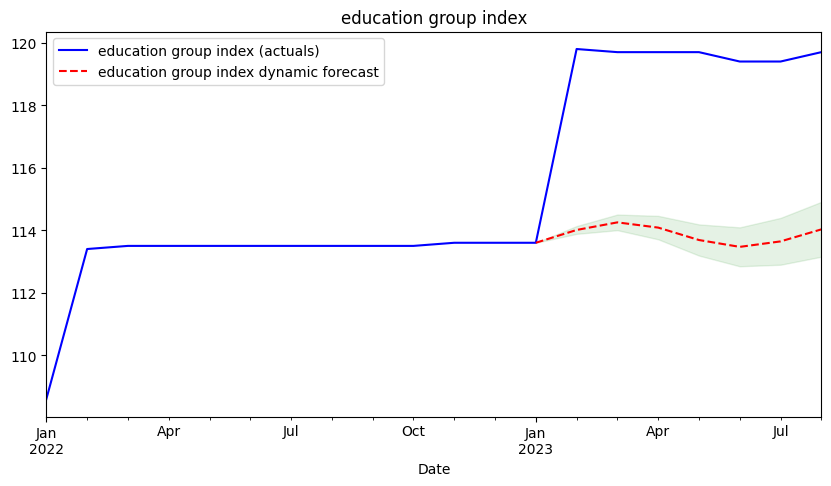

finance index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0099
ARIMA(0, 0, 2) RMSE = 0.0100
ARIMA(0, 0, 3) RMSE = 0.0088
ARIMA(0, 0, 4) RMSE = 0.0089
ARIMA(0, 0, 5) RMSE = 0.0090
ARIMA(0, 0, 6) RMSE = 0.0073
ARIMA(1, 0, 0) RMSE = 0.0099
ARIMA(1, 0, 1) RMSE = 0.0099
ARIMA(1, 0, 2) RMSE = 0.0065
ARIMA(1, 0, 3) RMSE = 0.0088
ARIMA(1, 0, 4) RMSE = 0.0089
ARIMA(1, 0, 5) RMSE = 0.0082
ARIMA(1, 0, 6) RMSE = 0.0067
ARIMA(2, 0, 0) RMSE = 0.0095
ARIMA(2, 0, 1) RMSE = 0.0099
ARIMA(2, 0, 2) RMSE = 0.0073
ARIMA(2, 0, 3) RMSE = 0.0082
ARIMA(2, 0, 4) RMSE = 0.0071
ARIMA(2, 0, 5) RMSE = 0.0076
ARIMA(2, 0, 6) RMSE = 0.0062
ARIMA(3, 0, 0) RMSE = 0.0038
ARIMA(3, 0, 1) RMSE = 0.0040
ARIMA(3, 0, 2) RMSE = 0.0042
ARIMA(3, 0, 3) RMSE = 0.0043
ARIMA(3, 0, 4) RMSE = 0.0059
ARIMA(3, 0, 5) RMSE = 0.0050
ARIMA(3, 0, 6) RMSE = 0.0045
ARIMA(4, 0, 0) RMSE = 0.0041
ARIMA(4, 0, 1) RMSE = 0.0037
ARIMA(4, 0, 2) RMSE = 0.0030
ARIMA(4, 0, 3) RMSE = 0.0042
ARIMA(4, 0, 4) RMSE = 0.0052
ARIMA(4, 0, 5) RMSE = 0.0059
ARIMA(4

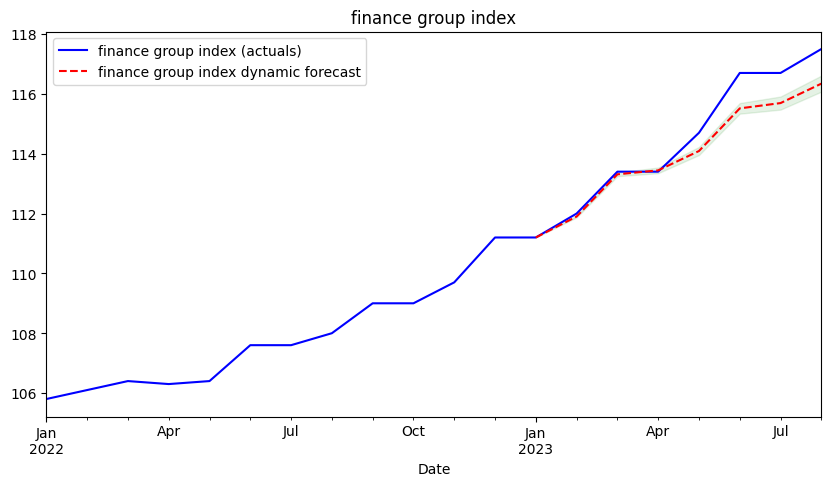

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# Define a function for date parsing
def date_parser(dates):
    return pd.to_datetime(dates, format='%d/%m/%Y')

# Load and preprocess data
def load_and_preprocess_data(cpi_csv_path, cpi_weights_csv_path):
    cpi_aus = pd.read_csv(cpi_csv_path, parse_dates=['Date'], index_col='Date', date_parser=date_parser)
    cpi_weights = pd.read_csv(cpi_weights_csv_path, parse_dates=['Date'], index_col='Date', date_parser=date_parser)

    column_mapping = {
        'All-groups': 'cpi',
        'Food and non-alcoholic beverages': 'food',
        'Alcohol and tobacco': 'alcohol',
        'Clothing and footwear': 'clothing',
        'Housing': 'housing',
        'Furnishings, household equipment and services': 'household',
        'Health': 'health',
        'Transport': 'transport',
        'Communication': 'communication',
        'Recreation and culture': 'recreation',
        'Education': 'education',
        'Insurance and financial services': 'finance'
    }
    cpi_aus.rename(columns=column_mapping, inplace=True)
    cpi_weights.rename(columns=column_mapping, inplace=True)

    # Create log and differenced log columns using vectorized operations
    columns_to_process = ['cpi', 'food', 'alcohol', 'clothing', 'housing', 'household', 'health', 'transport', 'communication', 'recreation', 'education', 'finance']
    cpi_aus[[f'log{column}' for column in columns_to_process]] = np.log(cpi_aus[columns_to_process] + 1e-10)
    cpi_aus[[f'dlog{column}' for column in columns_to_process]] = cpi_aus[[f'log{column}' for column in columns_to_process]].diff()

    return cpi_aus, cpi_weights

# Load and preprocess the data
# Australian Bureau of Statistics
# https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/monthly-consumer-price-index-indicator/latest-release#using-price-indexes
cpi_csv_path = '/content/drive/MyDrive/ .... /CPI_AUS_20231022.csv'
# Monthly Consumer Price Index Indicator, Weighting Pattern, Australia
# https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/monthly-consumer-price-index-indicator/jul-2023
cpi_weights_csv_path = '/content/drive/MyDrive/ .... /CPI_AUS_Weights_2022_2023.csv'
cpi_aus, cpi_weights = load_and_preprocess_data(cpi_csv_path, cpi_weights_csv_path)

# Define a function for ARIMA model evaluation
def arima_model_evaluate(actuals, validation, order):
    sarimax_model = SARIMAX(actuals, order=order).fit()
    prediction = sarimax_model.get_forecast(len(validation))
    predictions_df = prediction.conf_int()
    predictions_df["Predictions"] = sarimax_model.predict(start=predictions_df.index[0], end=predictions_df.index[-1])
    predictions_df.index = validation.index
    predictions_arima = predictions_df["Predictions"]
    rmse_score = rmse(validation, predictions_df["Predictions"])
    return rmse_score

# Define a function to optimize ARIMA model parameters
def optimize_arima(actuals, validation, p_values, d_values, q_values):
    best_rmse, best_config = float("inf"), None
    parameter_combinations = [(p, d, q) for p in p_values for d in d_values for q in q_values]
    for order in parameter_combinations:
        rmse_score = arima_model_evaluate(actuals, validation, order)
        if order == (0, 0, 0):
            continue
        elif rmse_score < best_rmse:
            best_rmse, best_config = rmse_score, order
        print(f'ARIMA{order} RMSE = {rmse_score:.4f}')
    print(f'Best Configuration: ARIMA{best_config}, RMSE = {best_rmse:.4f}')
    return best_config

# Train ARIMA model and get best configuration
t = 7
cpi_aus_train = cpi_aus.iloc[:-t]
cpi_aus_validation = cpi_aus.iloc[-t:]
p_values = range(0, 7)
d_values = range(0, 1)
q_values = range(0, 7)

variables = ['cpi', 'food', 'alcohol', 'clothing', 'housing', 'household', 'health', 'transport', 'communication', 'recreation', 'education', 'finance']
for var in variables:
    actuals = cpi_aus_train[f'dlog{var}'].dropna()
    validation = cpi_aus_validation[f'dlog{var}'].dropna()
    print(f'{var} index arima model selection')
    best_config = optimize_arima(actuals, validation, p_values, d_values, q_values)
    order = best_config
    # Train the final ARIMA model with the best configuration
    sarimax_model = SARIMAX(actuals, order=order).fit()
    prediction = sarimax_model.get_forecast(len(validation))
    predictions_df = prediction.conf_int(alpha=0.9)
    predictions_df['Predictions'] = sarimax_model.predict(start=predictions_df.index[0], end=predictions_df.index[-1])
    predictions_df.index = validation.index

    # Combine forecasted columns in the original DataFrame
    cpi_aus[f'dlog{var}_pred_m'] = predictions_df['Predictions']
    cpi_aus[f'log{var}pred_m'] = np.nan
    for i in range(t):
        if i == 0:
            cpi_aus[f'log{var}pred_m'].iloc[-t] = cpi_aus[f'log{var}'].iloc[-t-1] + cpi_aus[f'dlog{var}_pred_m'].iloc[-t]
        else:
            cpi_aus[f'log{var}pred_m'].iloc[-t+i] = cpi_aus[f'log{var}pred_m'].iloc[-t+i-1] + cpi_aus[f'dlog{var}_pred_m'].iloc[-t+i]
    cpi_aus[f'{var}pred'] = np.exp(cpi_aus[f'log{var}pred_m'])
    cpi_aus[f'{var}pred'].iloc[-t-1] = cpi_aus[f'{var}'].iloc[-t-1]

    cpi_aus[f'dlog{var}_pred_u'] = predictions_df[f'upper dlog{var}']
    cpi_aus[f'log{var}pred_u'] = np.nan
    for i in range(t):
        if i == 0:
            cpi_aus[f'log{var}pred_u'].iloc[-t] = cpi_aus[f'log{var}'].iloc[-t-1] + cpi_aus[f'dlog{var}_pred_u'].iloc[-t]
        else:
            cpi_aus[f'log{var}pred_u'].iloc[-t+i] = cpi_aus[f'log{var}pred_u'].iloc[-t+i-1] + cpi_aus[f'dlog{var}_pred_u'].iloc[-t+i]
    cpi_aus[f'{var}pred_upperbound'] = np.exp(cpi_aus[f'log{var}pred_u'])
    cpi_aus[f'{var}pred_upperbound'].iloc[-t-1] = cpi_aus[f'{var}'].iloc[-t-1]

    cpi_aus[f'dlog{var}_pred_l'] = predictions_df[f'lower dlog{var}']
    cpi_aus[f'log{var}pred_l'] = np.nan
    for i in range(t):
        if i == 0:
            cpi_aus[f'log{var}pred_l'].iloc[-t] = cpi_aus[f'log{var}'].iloc[-t-1] + cpi_aus[f'dlog{var}_pred_l'].iloc[-t]
        else:
            cpi_aus[f'log{var}pred_l'].iloc[-t+i] = cpi_aus[f'log{var}pred_l'].iloc[-t+i-1] + cpi_aus[f'dlog{var}_pred_l'].iloc[-t+i]
    cpi_aus[f'{var}pred_lowerbound'] = np.exp(cpi_aus[f'log{var}pred_l'])
    cpi_aus[f'{var}pred_lowerbound'].iloc[-t-1] = cpi_aus[f'{var}'].iloc[-t-1]

    # Plot the chart
    if var == 'cpi':
        cpi_aus_chart = cpi_aus.iloc[-20:]
        fig, ax = plt.subplots(figsize=(10, 5))
        cpi_aus_chart[f'{var}'].plot(ax=ax, style='b', label=f'{var} (actuals)')
        cpi_aus_chart[f'{var}pred'].plot(ax=ax, style='r--', label=f'{var} dynamic forecast')
        ax.fill_between(cpi_aus_chart.index, cpi_aus_chart[f'{var}pred_upperbound'], cpi_aus_chart[f'{var}pred_lowerbound'], color='g', alpha=0.1)
        plt.title('Consumer Price Index (CPI)')
        plt.legend()
        plt.show()
    else:
        cpi_aus_chart = cpi_aus.iloc[-20:]
        fig, ax = plt.subplots(figsize=(10, 5))
        cpi_aus_chart[f'{var}'].plot(ax=ax, style='b', label=f'{var} group index (actuals)')
        cpi_aus_chart[f'{var}pred'].plot(ax=ax, style='r--', label=f'{var} group index dynamic forecast')
        ax.fill_between(cpi_aus_chart.index, cpi_aus_chart[f'{var}pred_upperbound'], cpi_aus_chart[f'{var}pred_lowerbound'], color='g', alpha=0.1)
        plt.title(f'{var} group index')
        plt.legend()
        plt.show()

In [ ]:
prediction_matrix = cpi_aus.loc[:, ['foodpred', 'alcoholpred', 'clothingpred', 'housingpred', 'householdpred', 'healthpred', 'transportpred', 'communicationpred', 'recreationpred', 'educationpred', 'financepred']]
prediction_matrix_ub = cpi_aus.loc[:, ['foodpred_upperbound', 'alcoholpred_upperbound', 'clothingpred_upperbound', 'housingpred_upperbound', 'householdpred_upperbound', 'healthpred_upperbound', 'transportpred_upperbound', 'communicationpred_upperbound', 'recreationpred_upperbound', 'educationpred_upperbound', 'financepred_upperbound']]
prediction_matrix_lb = cpi_aus.loc[:, ['foodpred_lowerbound', 'alcoholpred_lowerbound', 'clothingpred_lowerbound', 'housingpred_lowerbound', 'householdpred_lowerbound', 'healthpred_lowerbound', 'transportpred_lowerbound', 'communicationpred_lowerbound', 'recreationpred_lowerbound', 'educationpred_lowerbound', 'financepred_lowerbound']]
prediction_matrix = prediction_matrix.iloc[-t-1: , :]
prediction_matrix_ub = prediction_matrix_ub.iloc[-t-1: , :]
prediction_matrix_lb = prediction_matrix_lb.iloc[-t-1: , :]
cpi_weights = cpi_weights.iloc[-t-2: , :]

In [ ]:
prediction_matrix

,foodpred,alcoholpred,clothingpred,housingpred,householdpred,healthpred,transportpred,communicationpred,recreationpred,educationpred,financepred
Date,,,,,,,,,,,
2023-01-01,122.300000,132.800000,100.600000,118.200000,115.000000,118.100000,124.900000,89.100000,114.600000,113.600000,111.200000
2023-02-01,122.759886,133.714545,101.970583,119.119236,115.095094,118.428249,125.301524,89.395109,108.668023,114.009975,111.901122
2023-03-01,123.096093,134.529576,102.952273,119.752026,114.978708,118.547571,124.906396,89.535526,111.611143,114.252819,113.311453
2023-04-01,123.070417,135.008641,104.121520,120.494902,115.421281,118.590894,125.383109,89.583642,110.750239,114.085406,113.444062
2023-05-01,123.401767,135.008360,103.265896,121.021688,115.254997,118.606616,125.676573,89.763487,110.356573,113.687967,114.091056
2023-06-01,123.507867,134.772262,102.261838,121.595161,115.208675,118.612321,125.657160,89.770129,113.495463,113.468647,115.515912
2023-07-01,123.301571,135.021794,101.722887,122.148639,115.274638,118.614391,125.638978,89.755032,112.107052,113.644201,115.693122
2023-08-01,123.551261,135.741618,102.413868,122.627686,115.257767,118.615142,126.128729,89.898565,110.476310,114.028332,116.342375


In [ ]:
prediction_matrix['cpi_aggregate_predict'] = np.nan
prediction_matrix['cpi_aggregate_predict_ec'] = np.nan
prediction_matrix['cpi_aggregate_predict'] = (prediction_matrix['foodpred'] * cpi_weights['food'] / 100) + (prediction_matrix['alcoholpred'] * cpi_weights['alcohol']/100) ++ (prediction_matrix['clothingpred'] * cpi_weights['clothing']/100) + (prediction_matrix['housingpred'] * cpi_weights['housing']/ 100) + (prediction_matrix['householdpred'] * cpi_weights['household']/100) + (prediction_matrix['healthpred'] * cpi_weights['health']/100) + (prediction_matrix['transportpred'] * cpi_weights['transport']/100) + (prediction_matrix['communicationpred'] * cpi_weights['communication']/100) + (prediction_matrix['recreationpred'] * cpi_weights['recreation']/100) + (prediction_matrix['educationpred'] * cpi_weights['education']/100) + (prediction_matrix['financepred'] * cpi_weights['finance']/100)
weights_error_correction = cpi_aus['cpi']['2022-12-01'] / prediction_matrix['cpi_aggregate_predict'].iloc[0]
prediction_matrix['cpi_aggregate_predict_ec'].iloc[1:] = prediction_matrix['cpi_aggregate_predict'].iloc[1:] * weights_error_correction
cpi_aus = pd.concat([cpi_aus, prediction_matrix], axis = 1)

prediction_matrix_ub['cpi_aggregate_predict_ub'] = np.nan
prediction_matrix_ub['cpi_aggregate_predict_ub_ec'] = np.nan
prediction_matrix_ub['cpi_aggregate_predict_ub'] = (prediction_matrix_ub['foodpred_upperbound'] * cpi_weights['food'] / 100) + (prediction_matrix_ub['alcoholpred_upperbound'] * cpi_weights['alcohol']/100) + (prediction_matrix_ub['clothingpred_upperbound'] * cpi_weights['clothing']/100) + (prediction_matrix_ub['housingpred_upperbound'] * cpi_weights['housing']/ 100) + (prediction_matrix_ub['householdpred_upperbound'] * cpi_weights['household']/100) + (prediction_matrix_ub['healthpred_upperbound'] * cpi_weights['health']/100) + (prediction_matrix_ub['transportpred_upperbound'] * cpi_weights['transport']/100) + (prediction_matrix_ub['communicationpred_upperbound'] * cpi_weights['communication']/100) + (prediction_matrix_ub['recreationpred_upperbound'] * cpi_weights['recreation']/100) + (prediction_matrix_ub['educationpred_upperbound'] * cpi_weights['education']/100) + (prediction_matrix_ub['financepred_upperbound'] * cpi_weights['finance']/100)
weights_error_correction = cpi_aus['cpi']['2022-12-01'] / prediction_matrix_ub['cpi_aggregate_predict_ub'].iloc[0]
prediction_matrix_ub['cpi_aggregate_predict_ub_ec'].iloc[1:] = prediction_matrix_ub['cpi_aggregate_predict_ub'].iloc[1:] * weights_error_correction
cpi_aus = pd.concat([cpi_aus, prediction_matrix_ub], axis = 1)

prediction_matrix_lb['cpi_aggregate_predict_lb'] = np.nan
prediction_matrix_lb['cpi_aggregate_predict_lb_ec'] = np.nan
prediction_matrix_lb['cpi_aggregate_predict_lb'] = (prediction_matrix_lb['foodpred_lowerbound'] * cpi_weights['food'] / 100) + (prediction_matrix_lb['alcoholpred_lowerbound'] * cpi_weights['alcohol']/100) + (prediction_matrix_lb['clothingpred_lowerbound'] * cpi_weights['clothing']/100) + (prediction_matrix_lb['housingpred_lowerbound'] * cpi_weights['housing']/ 100) + (prediction_matrix_lb['householdpred_lowerbound'] * cpi_weights['household']/100) + (prediction_matrix_lb['healthpred_lowerbound'] * cpi_weights['health']/100) + (prediction_matrix_lb['transportpred_lowerbound'] * cpi_weights['transport']/100) + (prediction_matrix_lb['communicationpred_lowerbound'] * cpi_weights['communication']/100) + (prediction_matrix_lb['recreationpred_lowerbound'] * cpi_weights['recreation']/100) + (prediction_matrix_lb['educationpred_lowerbound'] * cpi_weights['education']/100) + (prediction_matrix_lb['financepred_lowerbound'] * cpi_weights['finance']/100)
weights_error_correction = cpi_aus['cpi']['2022-12-01'] / prediction_matrix_lb['cpi_aggregate_predict_lb'].iloc[0]
prediction_matrix_lb['cpi_aggregate_predict_lb_ec'].iloc[1:] = prediction_matrix_lb['cpi_aggregate_predict_lb'].iloc[1:] * weights_error_correction
cpi_aus = pd.concat([cpi_aus, prediction_matrix_lb], axis = 1)

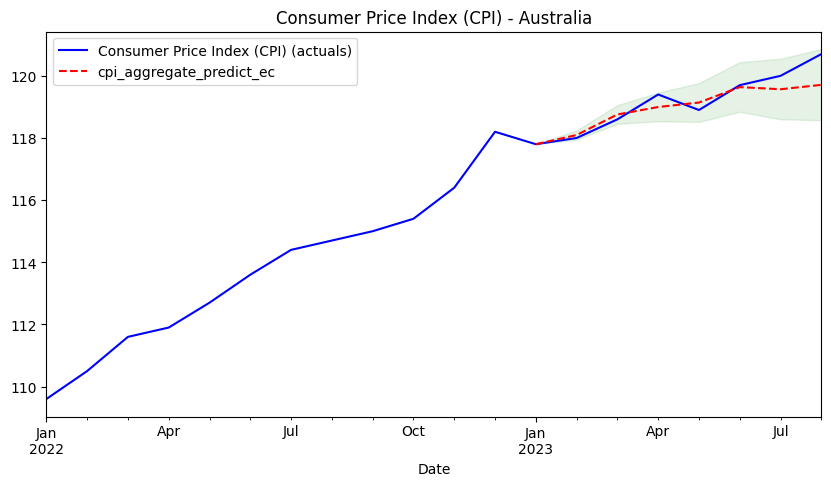

In [ ]:
cpi_aus['cpi_aggregate_predict_ec'].iloc[-t-1] = cpi_aus['cpi'].iloc[-t-1]
cpi_aus['cpi_aggregate_predict_ub_ec'].iloc[-t-1] = cpi_aus['cpi'].iloc[-t-1]
cpi_aus['cpi_aggregate_predict_lb_ec'].iloc[-t-1] = cpi_aus['cpi'].iloc[-t-1]
# Plot the chart
cpi_aus_chart = cpi_aus.iloc[-20:]
fig, ax = plt.subplots(figsize=(10, 5))
cpi_aus_chart['cpi'].plot(ax=ax, style='b', label='Consumer Price Index (CPI) (actuals)')
cpi_aus_chart['cpi_aggregate_predict_ec'].plot(ax=ax, style='r--', label='cpi_aggregate_predict_ec')
ax.fill_between(cpi_aus_chart.index, cpi_aus_chart['cpi_aggregate_predict_ub_ec'], cpi_aus_chart['cpi_aggregate_predict_lb_ec'], color='g', alpha=0.1)
plt.title('Consumer Price Index (CPI) - Australia')
plt.legend()
plt.show()

In [ ]:
cpi_aus.tail(10)

,cpi,food,alcohol,clothing,housing,household,health,transport,communication,recreation,...,housingpred_lowerbound,householdpred_lowerbound,healthpred_lowerbound,transportpred_lowerbound,communicationpred_lowerbound,recreationpred_lowerbound,educationpred_lowerbound,financepred_lowerbound,cpi_aggregate_predict_lb,cpi_aggregate_predict_lb_ec
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-01,116.4,121.4,132.7,103.2,116.0,116.1,117.0,127.1,88.9,106.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01,118.2,122.4,132.4,104.4,117.2,116.9,117.2,124.5,89.1,118.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,117.8,122.3,132.8,100.6,118.2,115.0,118.1,124.9,89.1,114.6,...,118.200000,115.000000,118.100000,124.900000,89.100000,114.600000,113.600000,111.200000,118.225210,117.800000
2023-02-01,118.0,123.5,134.4,102.1,118.5,115.8,118.1,127.2,89.4,107.7,...,119.074552,114.779396,118.315655,125.030942,89.332617,108.354804,113.885271,111.870358,117.973739,117.948583
2023-03-01,118.6,124.0,135.4,102.3,118.8,116.1,121.2,126.9,89.4,108.3,...,119.662169,114.348816,118.315085,124.362628,89.409288,110.956214,114.002690,113.249141,118.481184,118.455919
2023-04-01,119.4,124.3,135.6,104.2,119.2,117.8,121.3,128.1,88.8,111.3,...,120.355345,114.473864,118.237709,124.562226,89.393197,109.719730,113.710663,113.349684,118.562529,118.537247
2023-05-01,118.9,125.6,135.7,102.2,119.4,118.2,121.3,125.6,89.5,106.4,...,120.829717,113.967604,118.132758,124.577541,89.508441,108.936070,113.190101,113.956382,118.542075,118.516797
2023-06-01,119.7,125.5,135.5,100.4,119.7,118.3,121.5,126.9,88.5,111.5,...,121.348997,113.575795,118.017916,124.281478,89.450409,111.630933,112.847383,115.338752,118.868887,118.843540
2023-07-01,120.0,125.3,135.5,102.9,121.3,118.5,121.5,126.8,89.2,109.8,...,121.847404,113.295576,117.899569,123.986287,89.368406,109.866463,112.897448,115.474570,118.625625,118.600330


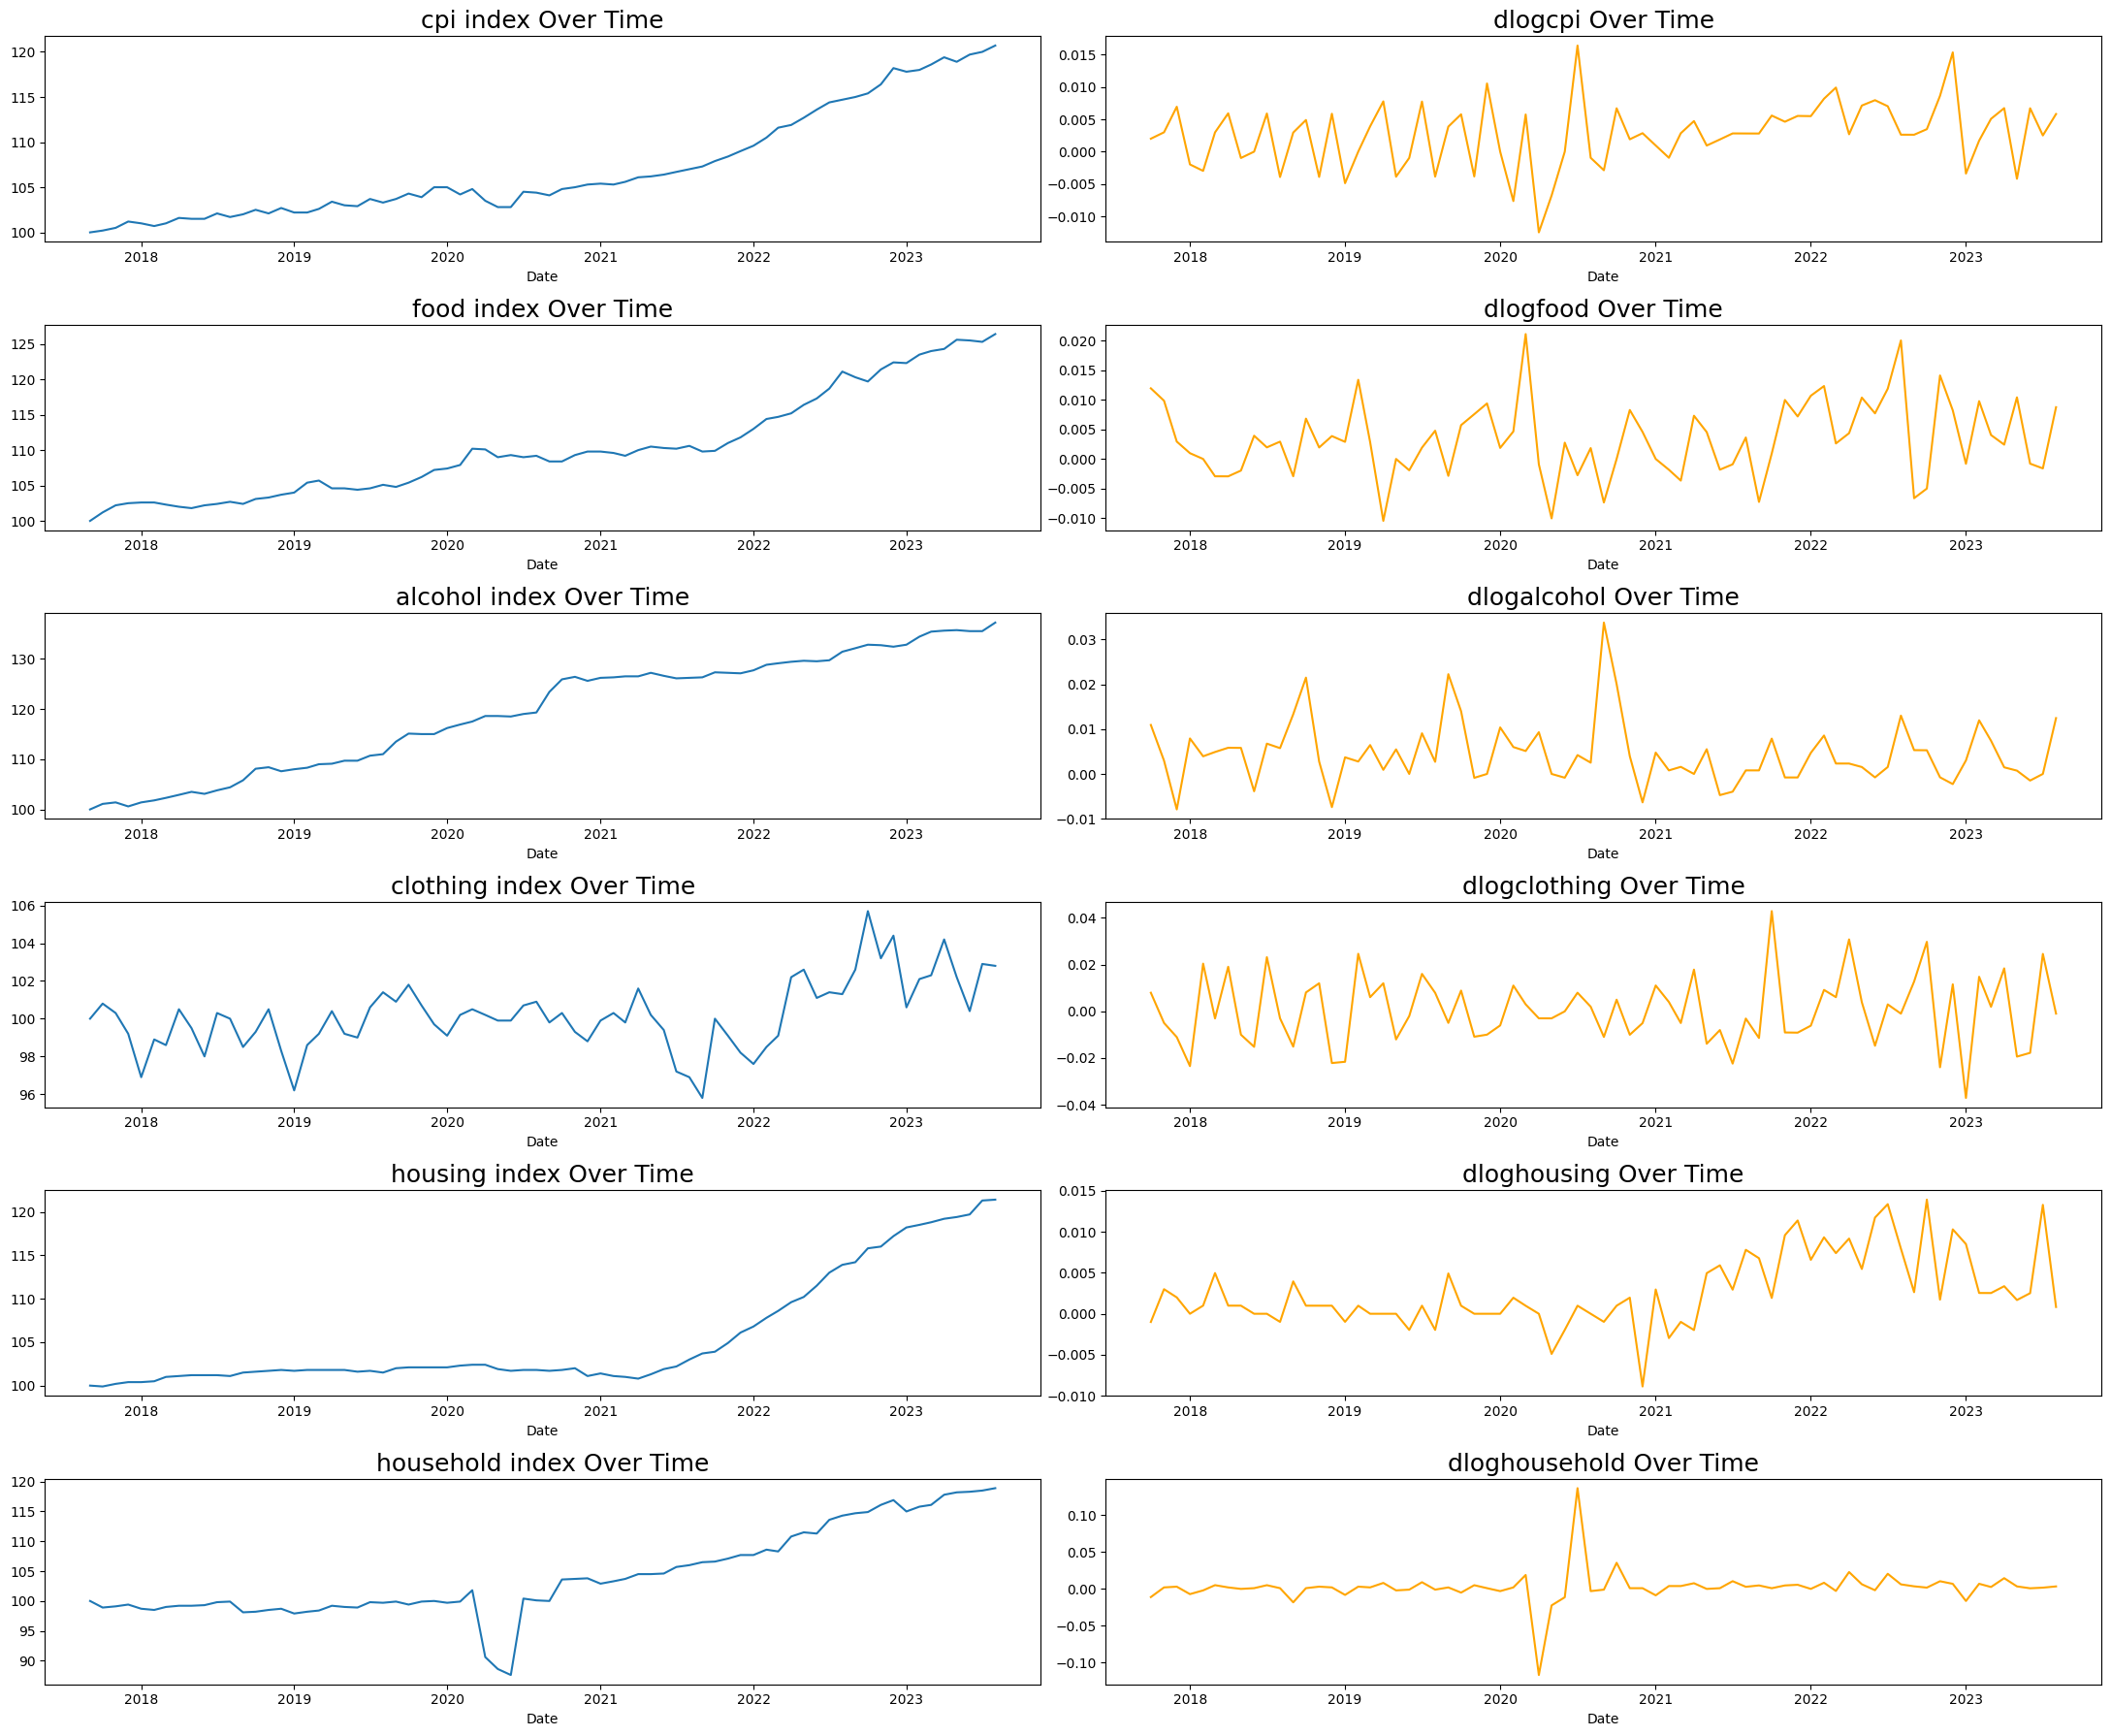

In [ ]:
columns = ['cpi', 'food', 'alcohol', 'clothing', 'housing', 'household']
# Plot each variable in separate subplots within a single large plot
fig, axes = plt.subplots(len(columns), 2, figsize=(22, 18))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(columns):
    # Plot log(col) in the left subplot
    axes[i, 0].plot(cpi_aus.index, cpi_aus[f'{col}'], label=f'{col}')
    axes[i, 0].set_title(f'{col} index Over Time', fontsize=18)
    axes[i, 0].set_xlabel('Date')
    #axes[i, 0].set_ylabel(f'{col}')

    # Plot dlog(col) in the right subplot
    axes[i, 1].plot(cpi_aus.index, cpi_aus[f'dlog{col}'], label=f'dlog{col}', color='orange')
    axes[i, 1].set_title(f'dlog{col} Over Time', fontsize=18)
    axes[i, 1].set_xlabel('Date')
    #axes[i, 1].set_ylabel(f'dlog{col}')

plt.tight_layout()
plt.show()

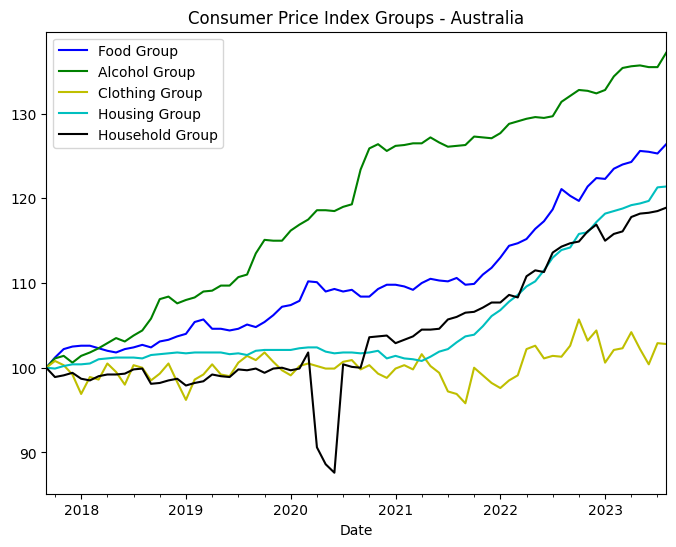

In [ ]:
# Plot the chart
fig, ax = plt.subplots(figsize=(8, 6))
cpi_aus_chart = cpi_aus.iloc[0:]
#plt.figure(figsize=(12, 6))
cpi_aus_chart['food'].plot(ax=ax, style='b', label='Food Group')
cpi_aus_chart['alcohol'].plot(ax=ax, style='g', label='Alcohol Group')
cpi_aus_chart['clothing'].plot(ax=ax, style='y', label='Clothing Group')
cpi_aus_chart['housing'].plot(ax=ax, style='c', label='Housing Group')
cpi_aus_chart['household'].plot(ax=ax, style='k', label='Household Group')
plt.title('Consumer Price Index Groups - Australia')
plt.legend()
plt.show()

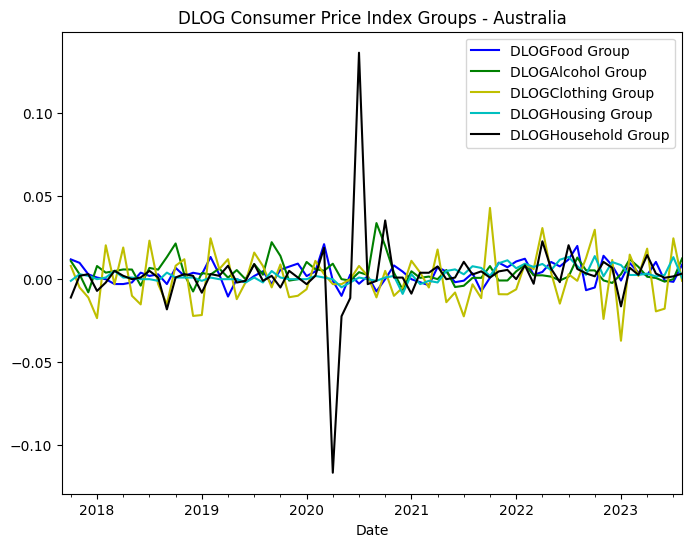

In [ ]:
# Plot the chart
fig, ax = plt.subplots(figsize=(8, 6))
cpi_aus_chart = cpi_aus.iloc[0:]
#plt.figure(figsize=(12, 6))
cpi_aus_chart['dlogfood'].plot(ax=ax, style='b', label='DLOGFood Group')
cpi_aus_chart['dlogalcohol'].plot(ax=ax, style='g', label='DLOGAlcohol Group')
cpi_aus_chart['dlogclothing'].plot(ax=ax, style='y', label='DLOGClothing Group')
cpi_aus_chart['dloghousing'].plot(ax=ax, style='c', label='DLOGHousing Group')
cpi_aus_chart['dloghousehold'].plot(ax=ax, style='k', label='DLOGHousehold Group')
plt.title('DLOG Consumer Price Index Groups - Australia')
plt.legend()
plt.show()

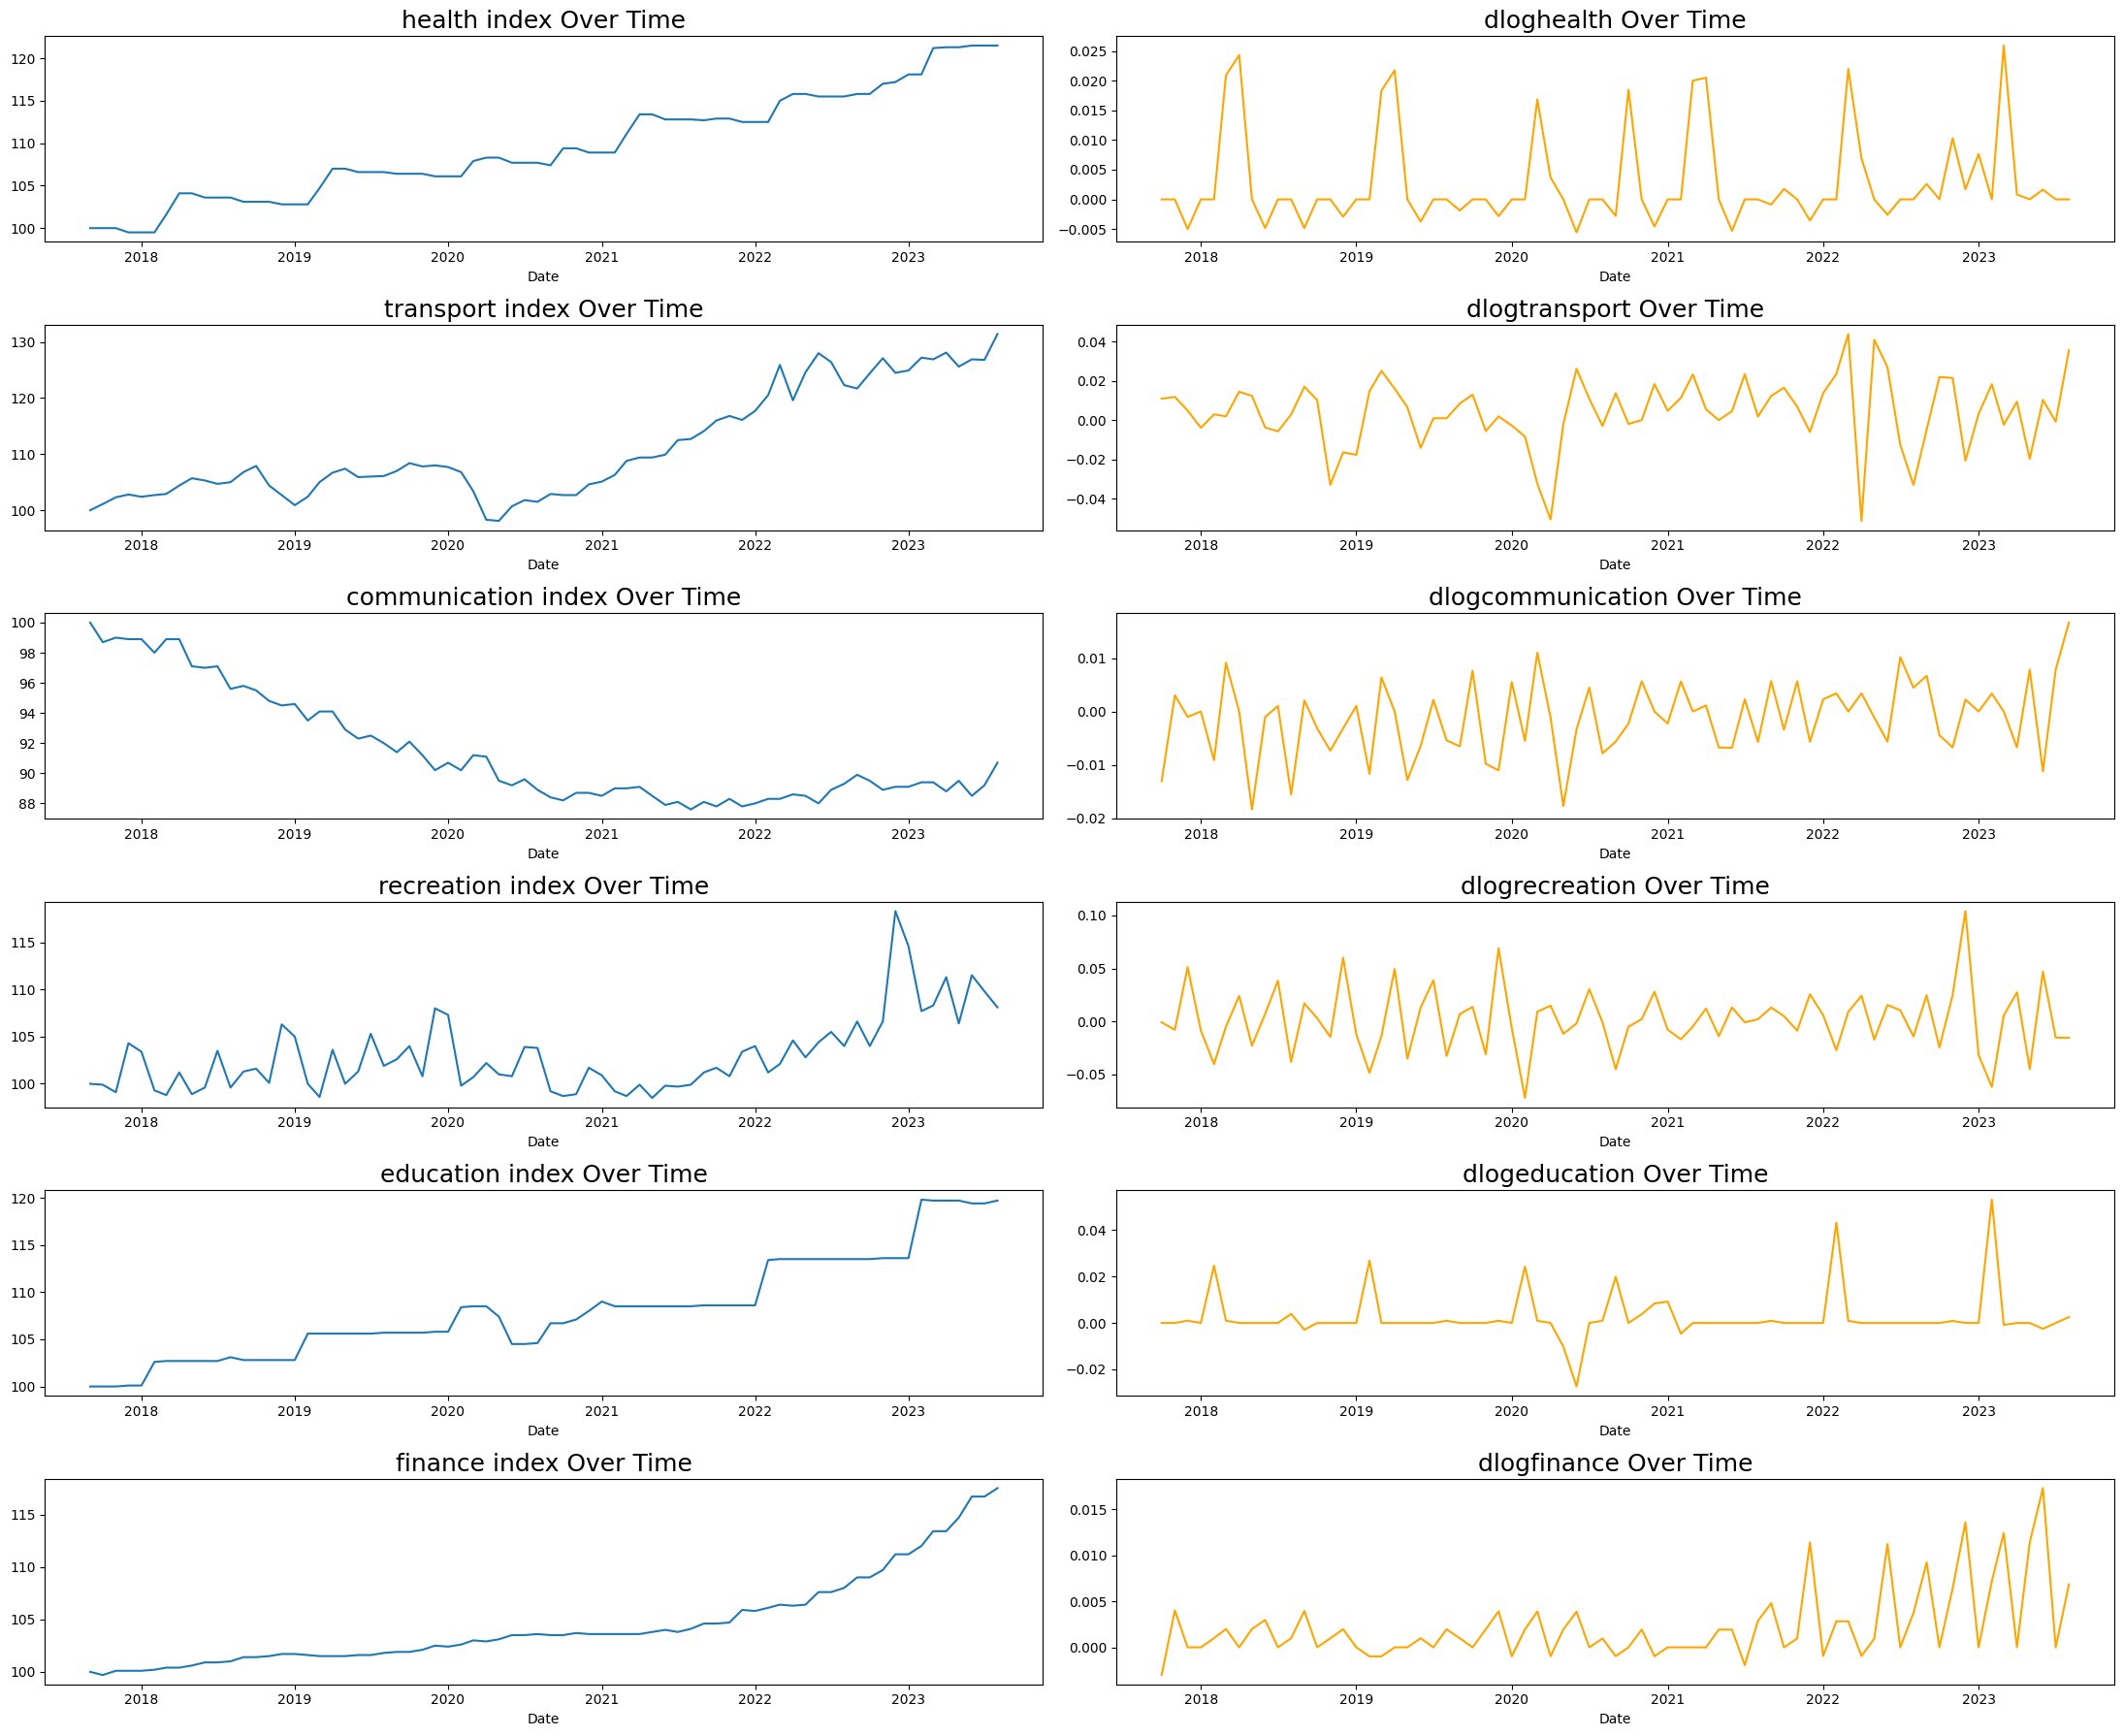

In [ ]:
columns = ['health', 'transport', 'communication', 'recreation', 'education', 'finance']
# Plot each variable in separate subplots within a single large plot
fig, axes = plt.subplots(len(columns), 2, figsize=(22, 18))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(columns):
    # Plot log(col) in the left subplot
    axes[i, 0].plot(cpi_aus.index, cpi_aus[f'{col}'], label=f'{col}')
    axes[i, 0].set_title(f'{col} index Over Time', fontsize=18)
    axes[i, 0].set_xlabel('Date')
    #axes[i, 0].set_ylabel(f'{col}')

    # Plot dlog(col) in the right subplot
    axes[i, 1].plot(cpi_aus.index, cpi_aus[f'dlog{col}'], label=f'dlog{col}', color='orange')
    axes[i, 1].set_title(f'dlog{col} Over Time', fontsize=18)
    axes[i, 1].set_xlabel('Date')
    #axes[i, 1].set_ylabel(f'dlog{col}')

plt.tight_layout()
plt.show()

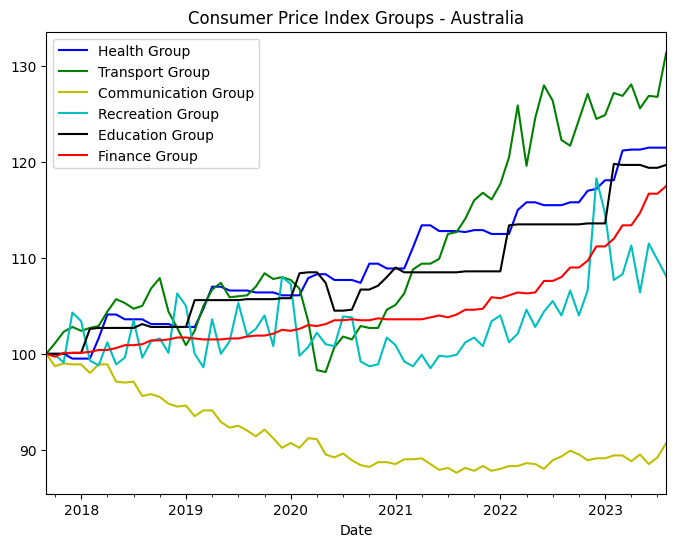

In [ ]:
# Plot the chart
fig, ax = plt.subplots(figsize=(8, 6))
cpi_aus_chart = cpi_aus.iloc[0:]
#plt.figure(figsize=(12, 6))
cpi_aus_chart['health'].plot(ax=ax, style='b', label='Health Group')
cpi_aus_chart['transport'].plot(ax=ax, style='g', label='Transport Group')
cpi_aus_chart['communication'].plot(ax=ax, style='y', label='Communication Group')
cpi_aus_chart['recreation'].plot(ax=ax, style='c', label='Recreation Group')
cpi_aus_chart['education'].plot(ax=ax, style='k', label='Education Group')
cpi_aus_chart['finance'].plot(ax=ax, style='r', label='Finance Group')
plt.title('Consumer Price Index Groups - Australia')
plt.legend()
plt.show()

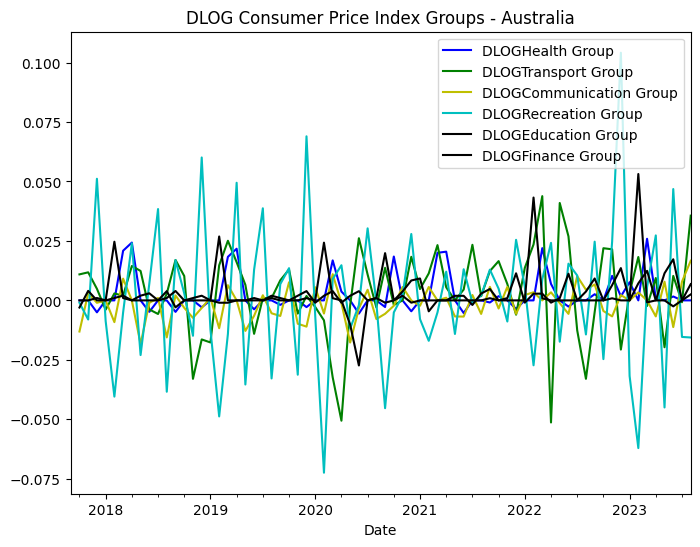

In [ ]:
# Plot the chart
fig, ax = plt.subplots(figsize=(8, 6))
cpi_aus_chart = cpi_aus.iloc[0:]
#plt.figure(figsize=(12, 6))
cpi_aus_chart['dloghealth'].plot(ax=ax, style='b', label='DLOGHealth Group')
cpi_aus_chart['dlogtransport'].plot(ax=ax, style='g', label='DLOGTransport Group')
cpi_aus_chart['dlogcommunication'].plot(ax=ax, style='y', label='DLOGCommunication Group')
cpi_aus_chart['dlogrecreation'].plot(ax=ax, style='c', label='DLOGRecreation Group')
cpi_aus_chart['dlogeducation'].plot(ax=ax, style='k', label='DLOGEducation Group')
cpi_aus_chart['dlogfinance'].plot(ax=ax, style='k', label='DLOGFinance Group')
plt.title('DLOG Consumer Price Index Groups - Australia')
plt.legend()
plt.show()